In [1]:
from functools import partial
from nd2_combine import tools
import numpy as np
import pandas as pd
import pims_nd2 as nd
import matplotlib.pyplot as plt
from droplet_growth import multiwell
import seaborn as sns
from segment import seg

In [2]:
def segment_bf(well, thr=0.2, smooth=10, erode=10, fill=True, plot=False, verbose=0):
    '''
    Serments input 2d array using thresholded gradient with filling
    
    1. get gradient
    2. smooth with sigma
    3. threshold according to max * thr
    4. fill holes
    5. erode
    
    Returns labels
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    if verbose:
        print(f'{n_labels} regions')
    if plot:
        fig, ax = multiwell.plt.subplots(1,2)
        ax[0].imshow(sm, cmap='gray')
        ax[1].imshow(labels)
        plt.show()
        
    return labels

In [3]:
def get_largest_feature(labels):
    props = multiwell.regionprops_table(labels, properties=('label', 'major_axis_length', 'perimeter', 'area',))
    df = pd.DataFrame(props)
    max_label = df.area.idxmax(axis=0)
    return df.query(f'label == {df.label.values[max_label]}')

In [4]:
path = '/home/aaristov/Multicell/Sebastien/mESC_aggregates/Time_evolution_spheroid/Wells.nd2'

In [5]:
reader = nd.ND2_Reader(path)

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/pims/base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


In [6]:
reader.sizes

{'x': 1024, 'y': 1022, 't': 33, 'm': 25}

In [7]:
reader.calibration

3.24166194425628

In [8]:
reader.default_coords['m'] = 0
reader.iter_axes = 't'

In [9]:
reader[0].metadata

{'x_um': 22022.5,
 'y_um': -23242.800000000003,
 'z_um': 5171.34,
 't_ms': 3088.991745108331,
 'colors': [(1.0, 1.0, 1.0)],
 'mpp': 3.24166194425628,
 'max_value': 65535,
 'x': 0,
 'y': 0,
 't': 0,
 'm': 0,
 'axes': ['y', 'x'],
 'coords': {'t': 0, 'm': 0}}

In [10]:
# for img in reader:
def get_shape(img, thr=.5, smooth=5, erode=1, plot=False, verbose=0):
    t = img.metadata['t']
    pixel_size_um = img.metadata['mpp']
    
    crop = seg.crop_center(img)
    if plot:
        plt.imshow(crop, cmap='gray')
        plt.show()
    lb = segment_bf(crop, thr=thr, smooth=smooth, erode=erode, plot=plot, verbose=verbose)
    data = get_largest_feature(lb)
    data['circularity'] = data.area / (data.perimeter ** 2) * 4 * np.pi
    data.index = [t]
    data.index.name = 'time'
    data['well'] = img.metadata['m']
    data['time'] = t
    data['major_axis_length'] = data['major_axis_length'] * pixel_size_um
    data['perimeter'] = data['perimeter'] * pixel_size_um
    data['area'] = data['area'] * pixel_size_um ** 2
    if verbose:
        print (data)
    return data[["time", "well", "major_axis_length",   "perimeter",  "area",  "circularity"]]

In [11]:
def get_single_well_shapes(well, reader, ):
    reader.default_coords['m'] = well
    reader.iter_axes = 't'
    print(f'Well #{well}')
    return pd.concat(list(map(get_shape, reader)))

def get_all_well_shapes(reader):
    ms = range(reader.sizes['m'])
    return pd.concat(list(map(partial(get_single_well_shapes, reader=reader), ms)))

In [12]:
df = get_all_well_shapes(reader)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Well #0
Well #1
Well #2
Well #3
Well #4
Well #5
Well #6
Well #7
Well #8
Well #9
Well #10
Well #11
Well #12
Well #13
Well #14
Well #15
Well #16
Well #17
Well #18
Well #19
Well #20
Well #21
Well #22
Well #23
Well #24


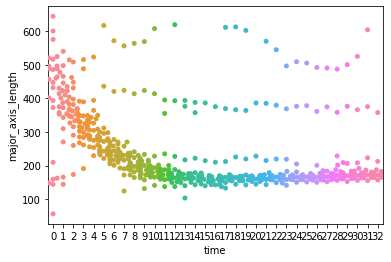

In [13]:
sns.swarmplot(data=df, x='time', y='major_axis_length')
plt.show()

In [14]:
good_wells = df.query('time == 18').query('major_axis_length < 200').well.values

fdf = df[df.well.isin(good_wells)]

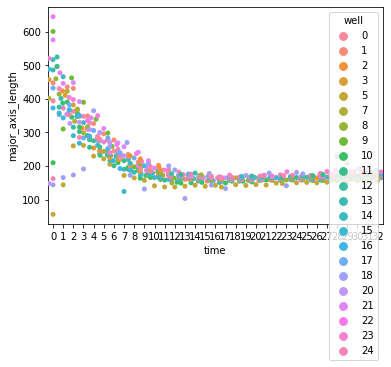

In [15]:
sns.swarmplot(data=fdf, x='time', y='major_axis_length', hue='well')
plt.show()

In [17]:
save_path = path.replace('.nd2', '.csv')

In [19]:
fdf.to_csv(save_path, index=None)

In [113]:
path.replace('Wells.nd2', 'Chip_Kinetic.csv')

'/home/aaristov/Multicell/Sebastien/mESC_aggregates/Time_evolution_spheroid/Chip_Kinetic.nd2'

In [14]:
chip = pd.read_csv(path.replace('Wells.nd2', 'Chip_Kinetic.csv'))
chip.time *= 0.5
fdf.time = fdf.time * 0.5

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


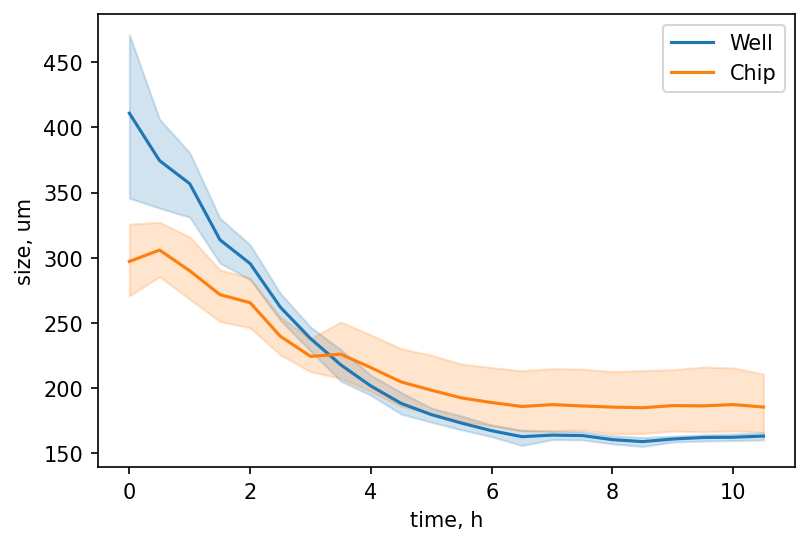

In [16]:
fig, ax = plt.subplots(dpi=150)
sns.lineplot(ax=ax, data=fdf.query('time < 11'), x='time', y='major_axis_length', label='Well')
sns.lineplot(ax=ax, data=chip.query('time < 11'), x='time', y='major_axis_length', label='Chip')
ax.set_ylabel('size, um')
ax.set_xlabel('time, h')
plt.savefig('well_chip_size.pdf')
# ax.xlim(0,20)
# sns.lineplot(ax=ax2, data=fdf, x='time', y='circularity', color='tab:orange')
# ax2.set_ylabel('circularity', color='tab:orange')

In [22]:
df.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
           dtype='int64', name='time', length=825)

Text(0, 0.5, 'circularity')

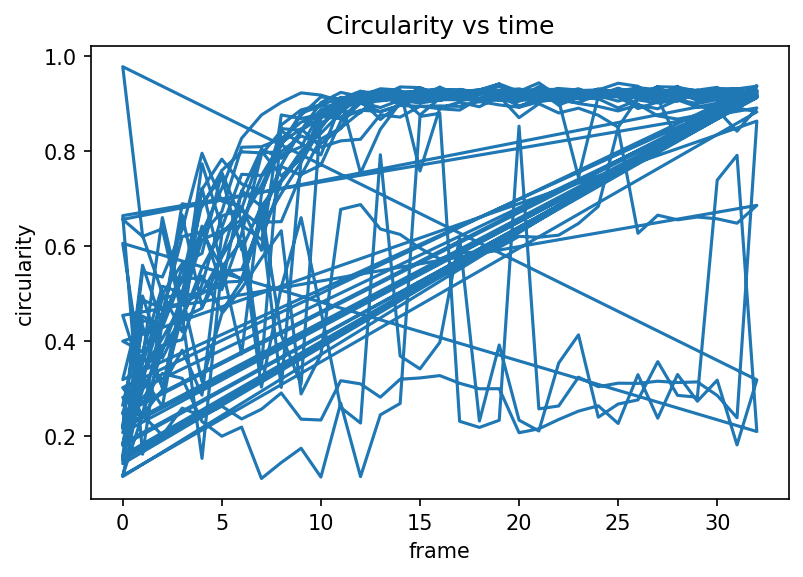

In [23]:
plt.figure(dpi=150)
df.circularity.plot()
plt.xlabel('frame')
plt.title('Circularity vs time')
plt.ylabel('circularity')

In [110]:
df

well  major_axis_length   perimeter  area  circularity
time                                                        
0        0         121.582529  646.949314  8839     0.265383
1        0         109.254801  422.617316  6433     0.452615
2        0         111.981147  444.818326  6759     0.429266
3        0          95.467435  347.119841  5123     0.534288
4        0          86.514518  300.391919  3809     0.530450
5        0          86.369475  296.534055  3557     0.508329
6        0          75.432380  251.279221  3148     0.626515
7        0          69.204167  212.592929  2853     0.793257
8        0          62.674606  189.722871  2414     0.842767
9        0          58.977562  181.722871  2144     0.815860
10       0          56.832836  182.066017  2090     0.792316
11       0          55.013401  166.267027  1978     0.899133
12       0          52.759176  161.438600  1898     0.915148
13       0          50.630133  157.781746  1805     0.911116
14       0          51.220562  156.710678  1786     0.913890
15       0          51.819758  159.781746  1780     0.876144
16       0          50.878795  156.710678  1781     0.911332
17       0          50.141308  156.124892  1775     0.915090
18       0          50.327121  154.710678  1768     0.928221
19       0          50.682103  156.953319  1791     0.913618
20       0          50.436337  156.953319  1810     0.923310
21       0          49.946640  156.710678  1801     0.921566
22       0          49.784367  157.296465  1835     0.931983
23       0          51.041778  160.124892  1895     0.928755
24       0          50.254142  159.539105  1873     0.924727
25       0          50.419998  160.710678  1902     0.925403
26       0          51.103711  163.781746  1951     0.913979
27       0          50.111780  161.296465  1918     0.926422
28       0          51.005696  164.710678  1967     0.911110
29       0          52.302700  168.367532  2069     0.917178
30       0          51.108547  166.710678  2033     0.919222
31       0          51.116368  165.195959  1986     0.914514
32       0          50.693365  164.610173  1974     0.915469